In [1]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "99"#tensorflow设置日志级别

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


这个笔记本的目的是建立一个模型(深层神经网络)与Tensorflow。我们会看到不同的步骤。本笔记本分为几个部分:
一、可进口设备
二世。离群值
三世。预处理
连续特征的dnnregression or
诉的预测
VI.泄漏继电器的例子
七世。用于连续和分类的DNNRegressor
八世。预测国际清算银行
第九。浅神经网络
x的结论
我们将公开3个模型。第一个将只使用连续特征，第二个我们将添加分类特征最后我们将使用只有一层的神经网络。
他们没有调优，我们将使用DNNRegressor with Relu进行所有激活功能，每层的单元数为:[200,100,50,25,12]。我们有5层。
在第6部分中，我将以Leaky Relu为例说明如何使用另一个激活函数。最后，我将尝试使用一个浅神经网络(只有一个隐藏层)只是为了好玩。
如果您有改进模型性能的想法:请与我们分享!叉!和它一起玩!


一、可进口设备
在进口之前，我更喜欢检查可用的设备。例如，有时我们的GPU会出现问题。如果你想有一个好的性能，你必须使用GPU，而不是CPU。在我们的示例中，我们只有一个CPU，但是现在您有代码来检查您的设备是否被检测到

In [2]:
os.getcwd()

'C:\\Users\\CDA\\Documents'

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15454351394157295489]

In [4]:
# Test with a simple computation
import tensorflow as tf

tf.Session()

with tf.device('/cpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3])
# If you have gpu you can try this line to compute b with your GPU
#with tf.device('/gpu:0'):    
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2])
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

print(sess.run(c))

# Runs the op.
# Log information
options = tf.RunOptions(output_partition_graphs=True)
metadata = tf.RunMetadata()
c_val = sess.run(c, options=options, run_metadata=metadata)

print(metadata.partition_graphs)

sess.close()

[[22. 28.]
 [49. 64.]]
[node {
  name: "_retval_MatMul_0_0"
  op: "_Retval"
  input: "MatMul/_0__cf__0"
  device: "/job:localhost/replica:0/task:0/device:CPU:0"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "index"
    value {
      i: 0
    }
  }
}
node {
  name: "MatMul/_0__cf__0"
  op: "Const"
  device: "/job:localhost/replica:0/task:0/device:CPU:0"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
          dim {
            size: 2
          }
          dim {
            size: 2
          }
        }
        tensor_content: "\000\000\260A\000\000\340A\000\000DB\000\000\200B"
      }
    }
  }
}
library {
}
versions {
  producer: 27
}
]


在本教程中，我们的数据由包含81个特性的1460行组成。38个连续特征和43个分类特征。正如在介绍中所揭示的，我们将只使用连续特性来构建我们的第一个模型。
这里的目标是预测房价。在这种情况下，我们需要构建一个回归模型。因此，我们的第一个数据将包含37个特性来解释“SalePrice”。我们可以看到将用于构建第一个模型的特性列表。

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler#该函数将X按行归一化

tf.logging.set_verbosity(tf.logging.INFO)
sess = tf.InteractiveSession()

train = pd.read_csv('D:/news/train.csv')
print('Shape of the train data with all features:', train.shape)
train = train.select_dtypes(exclude=['object'])#只留下数值型变量
print("")
print('Shape of the train data with numerical features:', train.shape)
train.drop('Id',axis = 1, inplace = True)#删除ID列
train.fillna(0,inplace=True)#缺失值用0填补

test = pd.read_csv('D:/news/test.csv')
test = test.select_dtypes(exclude=['object'])
ID = test.Id
test.fillna(0,inplace=True)
test.drop('Id',axis = 1, inplace = True)

print("")
print("List of features contained our dataset:",list(train.columns))

Shape of the train data with all features: (1460, 81)

Shape of the train data with numerical features: (1460, 38)

List of features contained our dataset: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


二世。离群值
在这一小部分中，我们将使用IsolationForest (http://scikit-learn.org/stable/modules/generated/sklearn.ble.isolationforest .html)来隔离异常值。我尝试了有和没有这一步，我有一个更好的性能删除这些行。
我还没有分析测试集，但是我想如果没有这些异常值，我们的火车集看起来更像我们的数据测试。

In [6]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [7]:
from sklearn.ensemble import IsolationForest#隔离森林算法，返回每个样本的异常分数使用IsolationForest算法

clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:214: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:224: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
        max_features=1.0, max_samples=100, n_estimators=100, n_jobs=None,
        random_state=42, verbose=0)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:418: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


array([   0,    1,    2, ..., 1456, 1458, 1459], dtype=int64)

Number of Outliers: 146
Number of rows without outliers: 1314


In [8]:
train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000
5,50,85.0,14115,5,5,1993,1995,0.0,732,0,...,40,30,0,320,0,0,700,10,2009,143000
6,20,75.0,10084,8,5,2004,2005,186.0,1369,0,...,255,57,0,0,0,0,0,8,2007,307000
7,50,51.0,6120,7,5,1931,1950,0.0,0,0,...,90,0,205,0,0,0,0,4,2008,129900
8,190,50.0,7420,5,6,1939,1950,0.0,851,0,...,0,4,0,0,0,0,0,1,2008,118000
9,20,70.0,11200,5,5,1965,1965,0.0,906,0,...,0,0,0,0,0,0,0,2,2008,129500


三世。预处理
为了重新缩放我们的数据，我们将使用Scikit-learn的MinMaxScaler函数。我想知道使用相同的MinMaxScaler进行训练和测试是否有趣!

In [9]:
import warnings
warnings.filterwarnings('ignore')

col_train = list(train.columns)
col_train_bis = list(train.columns)

col_train_bis.remove('SalePrice')

mat_train = np.matrix(train)
mat_test  = np.matrix(test)
mat_new = np.matrix(train.drop('SalePrice',axis = 1))
mat_y = np.array(train.SalePrice).reshape((1314,1))

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y)

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

train = pd.DataFrame(prepro.transform(mat_train),columns = col_train)
test  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

train.head()

MinMaxScaler(copy=True, feature_range=(0, 1))

MinMaxScaler(copy=True, feature_range=(0, 1))

MinMaxScaler(copy=True, feature_range=(0, 1))

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,0.235294,0.207668,0.062802,0.625,0.428571,0.953488,0.883333,0.12250,0.416274,0.0,...,0.000000,0.167582,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50,0.403057
1,0.000000,0.255591,0.072904,0.500,0.857143,0.744186,0.433333,0.00000,0.576651,0.0,...,0.404891,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25,0.340220
2,0.235294,0.217252,0.087396,0.625,0.428571,0.937984,0.866667,0.10125,0.286557,0.0,...,0.000000,0.115385,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50,0.437966
3,0.294118,0.191693,0.072464,0.625,0.428571,0.271318,0.333333,0.00000,0.127358,0.0,...,0.000000,0.096154,0.824242,0.0,0.0,0.0,0.0,0.090909,0.00,0.243639
4,0.235294,0.268371,0.113835,0.750,0.428571,0.930233,0.833333,0.21875,0.386203,0.0,...,0.260870,0.230769,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50,0.499638


要使用Tensorflow，我们需要以一种特殊的格式转换数据(特性)。提醒一下，我们只有连续的特征。因此使用的第一个函数是:tf.contrib.layers.real_valued_column。更多信息:https://www.tensorflow.org/api_docs/python/tf/contrib/layers/real_valued_column
其他单元格允许我们用我们的训练数据集创建一个训练集和测试集。

In [10]:
COLUMNS = col_train
FEATURES = col_train_bis
LABEL = "SalePrice"

# Columns for tensorflow
feature_cols = [tf.contrib.layers.real_valued_column(k) for k in FEATURES]

# Training set and Prediction set with the features to predict
training_set = train[COLUMNS]
prediction_set = train.SalePrice

# Train and Test 
x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES] , prediction_set, test_size=0.33, random_state=42)
y_train = pd.DataFrame(y_train, columns = [LABEL])
training_set = pd.DataFrame(x_train, columns = FEATURES).merge(y_train, left_index = True, right_index = True)
training_set.head()

# Training for submission
training_sub = training_set[col_train]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
1200,0.058824,0.488818,0.024752,0.250,0.285714,0.472868,0.000000,0.00,0.000000,0.0,...,0.000000,0.054945,0.0,0.000000,0.0,0.0,0.0,0.181818,0.00,0.040003
1134,0.235294,0.000000,0.205377,0.500,0.428571,0.922481,0.816667,0.00,0.000000,0.0,...,0.000000,0.282967,0.0,0.000000,0.0,0.0,0.0,0.454545,0.75,0.339057
826,0.000000,0.207668,0.078499,0.500,0.428571,0.968992,0.933333,0.00,0.016509,0.0,...,0.135870,0.000000,0.0,0.045276,0.0,0.0,0.0,0.818182,0.00,0.313434
1308,0.000000,0.287540,0.139808,0.375,0.428571,0.976744,0.933333,0.00,0.000000,0.0,...,0.048913,0.153846,0.0,0.000000,0.0,0.0,0.0,0.545455,0.00,0.114476
617,0.588235,0.194888,0.055134,0.500,0.428571,0.968992,0.933333,0.16,0.011792,0.0,...,0.260870,0.076923,0.0,0.000000,0.0,0.0,0.0,0.454545,0.25,0.370940


In [11]:
y_train.head()

,SalePrice
1200,0.040003
1134,0.339057
826,0.313434
1308,0.114476
617,0.370940


In [12]:
training_set.SalePrice

1200    0.040003
1134    0.339057
826     0.313434
1308    0.114476
617     0.370940
898     0.108658
376     0.397937
1094    0.178476
561     0.232003
314     0.138912
439     0.117967
442     0.319938
1065    0.161952
319     0.229675
629     0.760103
887     0.376293
5       0.250621
100     0.336730
424     0.941818
767     0.271566
613     0.400729
591     0.173821
996     0.557180
423     0.262257
1041    0.425166
461     0.285530
953     0.174985
1128    0.302752
227     0.453093
759     0.353020
          ...   
510     0.313457
1082    0.413529
474     0.355348
856     0.225021
747     0.215712
252     0.400729
21      0.220134
459     0.142403
1184    0.557820
276     0.755637
955     0.681165
1215    0.313457
385     0.116570
805     0.232003
343     0.364657
769     0.359886
130     0.220366
871     0.341384
1123    0.194766
87      0.138330
330     0.319042
1238    0.307639
466     0.287857
121     0.250621
1044    0.465027
1095    0.451827
1130    0.619492
1294    0.8362

In [13]:
# Same thing but for the test set
y_test = pd.DataFrame(y_test, columns = [LABEL])
testing_set = pd.DataFrame(x_test, columns = FEATURES).merge(y_test, left_index = True, right_index = True)
testing_set.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
1232,0.235294,0.239617,0.074221,0.625,0.571429,0.914729,0.800000,0.00000,0.574882,0.0,...,0.343750,0.467033,0.0,0.0,0.0,0.0,0.000000,0.454545,0.00,0.556191
76,0.352941,0.000000,0.063505,0.625,0.428571,0.891473,0.766667,0.01375,0.000000,0.0,...,0.163043,0.197802,0.0,0.0,0.0,0.0,0.045161,0.363636,0.75,0.309966
962,0.176471,0.159744,0.055205,0.375,0.142857,0.527132,0.000000,0.00000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.636364,0.00,0.130767
433,0.588235,0.102236,0.028107,0.500,0.428571,0.914729,0.800000,0.07250,0.528892,0.0,...,0.000000,0.343407,0.0,0.0,0.0,0.0,0.000000,0.363636,0.00,0.299493
1110,0.823529,0.115016,0.011665,0.625,0.428571,0.953488,0.883333,0.06625,0.000000,0.0,...,0.000000,0.074176,0.0,0.0,0.0,0.0,0.000000,0.454545,1.00,0.326257


四、连续特征深度神经网络
tf.contrib。学习深度神经网络是很容易实现的。在我们的例子中，我们将有5个隐藏层，分别是200、100、50、25和12个单元，激活的函数将是Relu。
在我们的例子中使用的优化器是Adagrad优化器(默认情况下)。

In [14]:
# Model
tf.logging.set_verbosity(tf.logging.ERROR)
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.relu, hidden_units=[200, 100, 50, 25, 12])#,
                                         #optimizer = tf.train.GradientDescentOptimizer( learning_rate= 0.1 ))

In [15]:
# Reset the index of training
training_set.reset_index(drop = True, inplace =True)

In [16]:
def input_fn(data_set, pred = False):
    
    if pred == False:
        
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        labels = tf.constant(data_set[LABEL].values)
        
        return feature_cols, labels

    if pred == True:
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        
        return feature_cols

In [17]:
#  利用训练集进行深度神经网络回归分析，该训练集包含了训练数据的分割
regressor.fit(input_fn=lambda: input_fn(training_set), steps=2000)

DNNRegressor(params={'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None, 'optimizer': None, 'feature_columns': (_RealValuedColumn(column_name='MSSubClass', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotFrontage', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotArea', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallQual', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallCond', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearBuilt', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearRemodAdd', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='MasVnrArea', dimension=1, default_value=None, d

In [18]:
# 对train_test_split创建的测试集求值
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)

In [19]:
# 在测试集上显示分数
# 0.002倍的平均
loss_score1 = ev["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score1))

Final Loss on the testing set: 0.002531


In [20]:
# Predictions
y = regressor.predict(input_fn=lambda: input_fn(testing_set))
predictions = list(itertools.islice(y, testing_set.shape[0]))

五、预测与提交
让我们准备我们的第一次提交!数据预处理:勾选!排除在外:检查!模型建立::检查!下一步:使用我们的模型进行数据集测试的预测。并添加一个图表，看看现实和预测之间的差异。

In [21]:
predictions = pd.DataFrame(prepro_y.inverse_transform(np.array(predictions).reshape(434,1)),columns = ['Prediction'])

In [22]:
reality = pd.DataFrame(prepro.inverse_transform(testing_set), columns = [COLUMNS]).SalePrice

Text(0.5, 0, 'Predictions')

Text(0, 0.5, 'Reality')

Text(0.5, 1.0, 'Predictions x Reality on dataset Test')

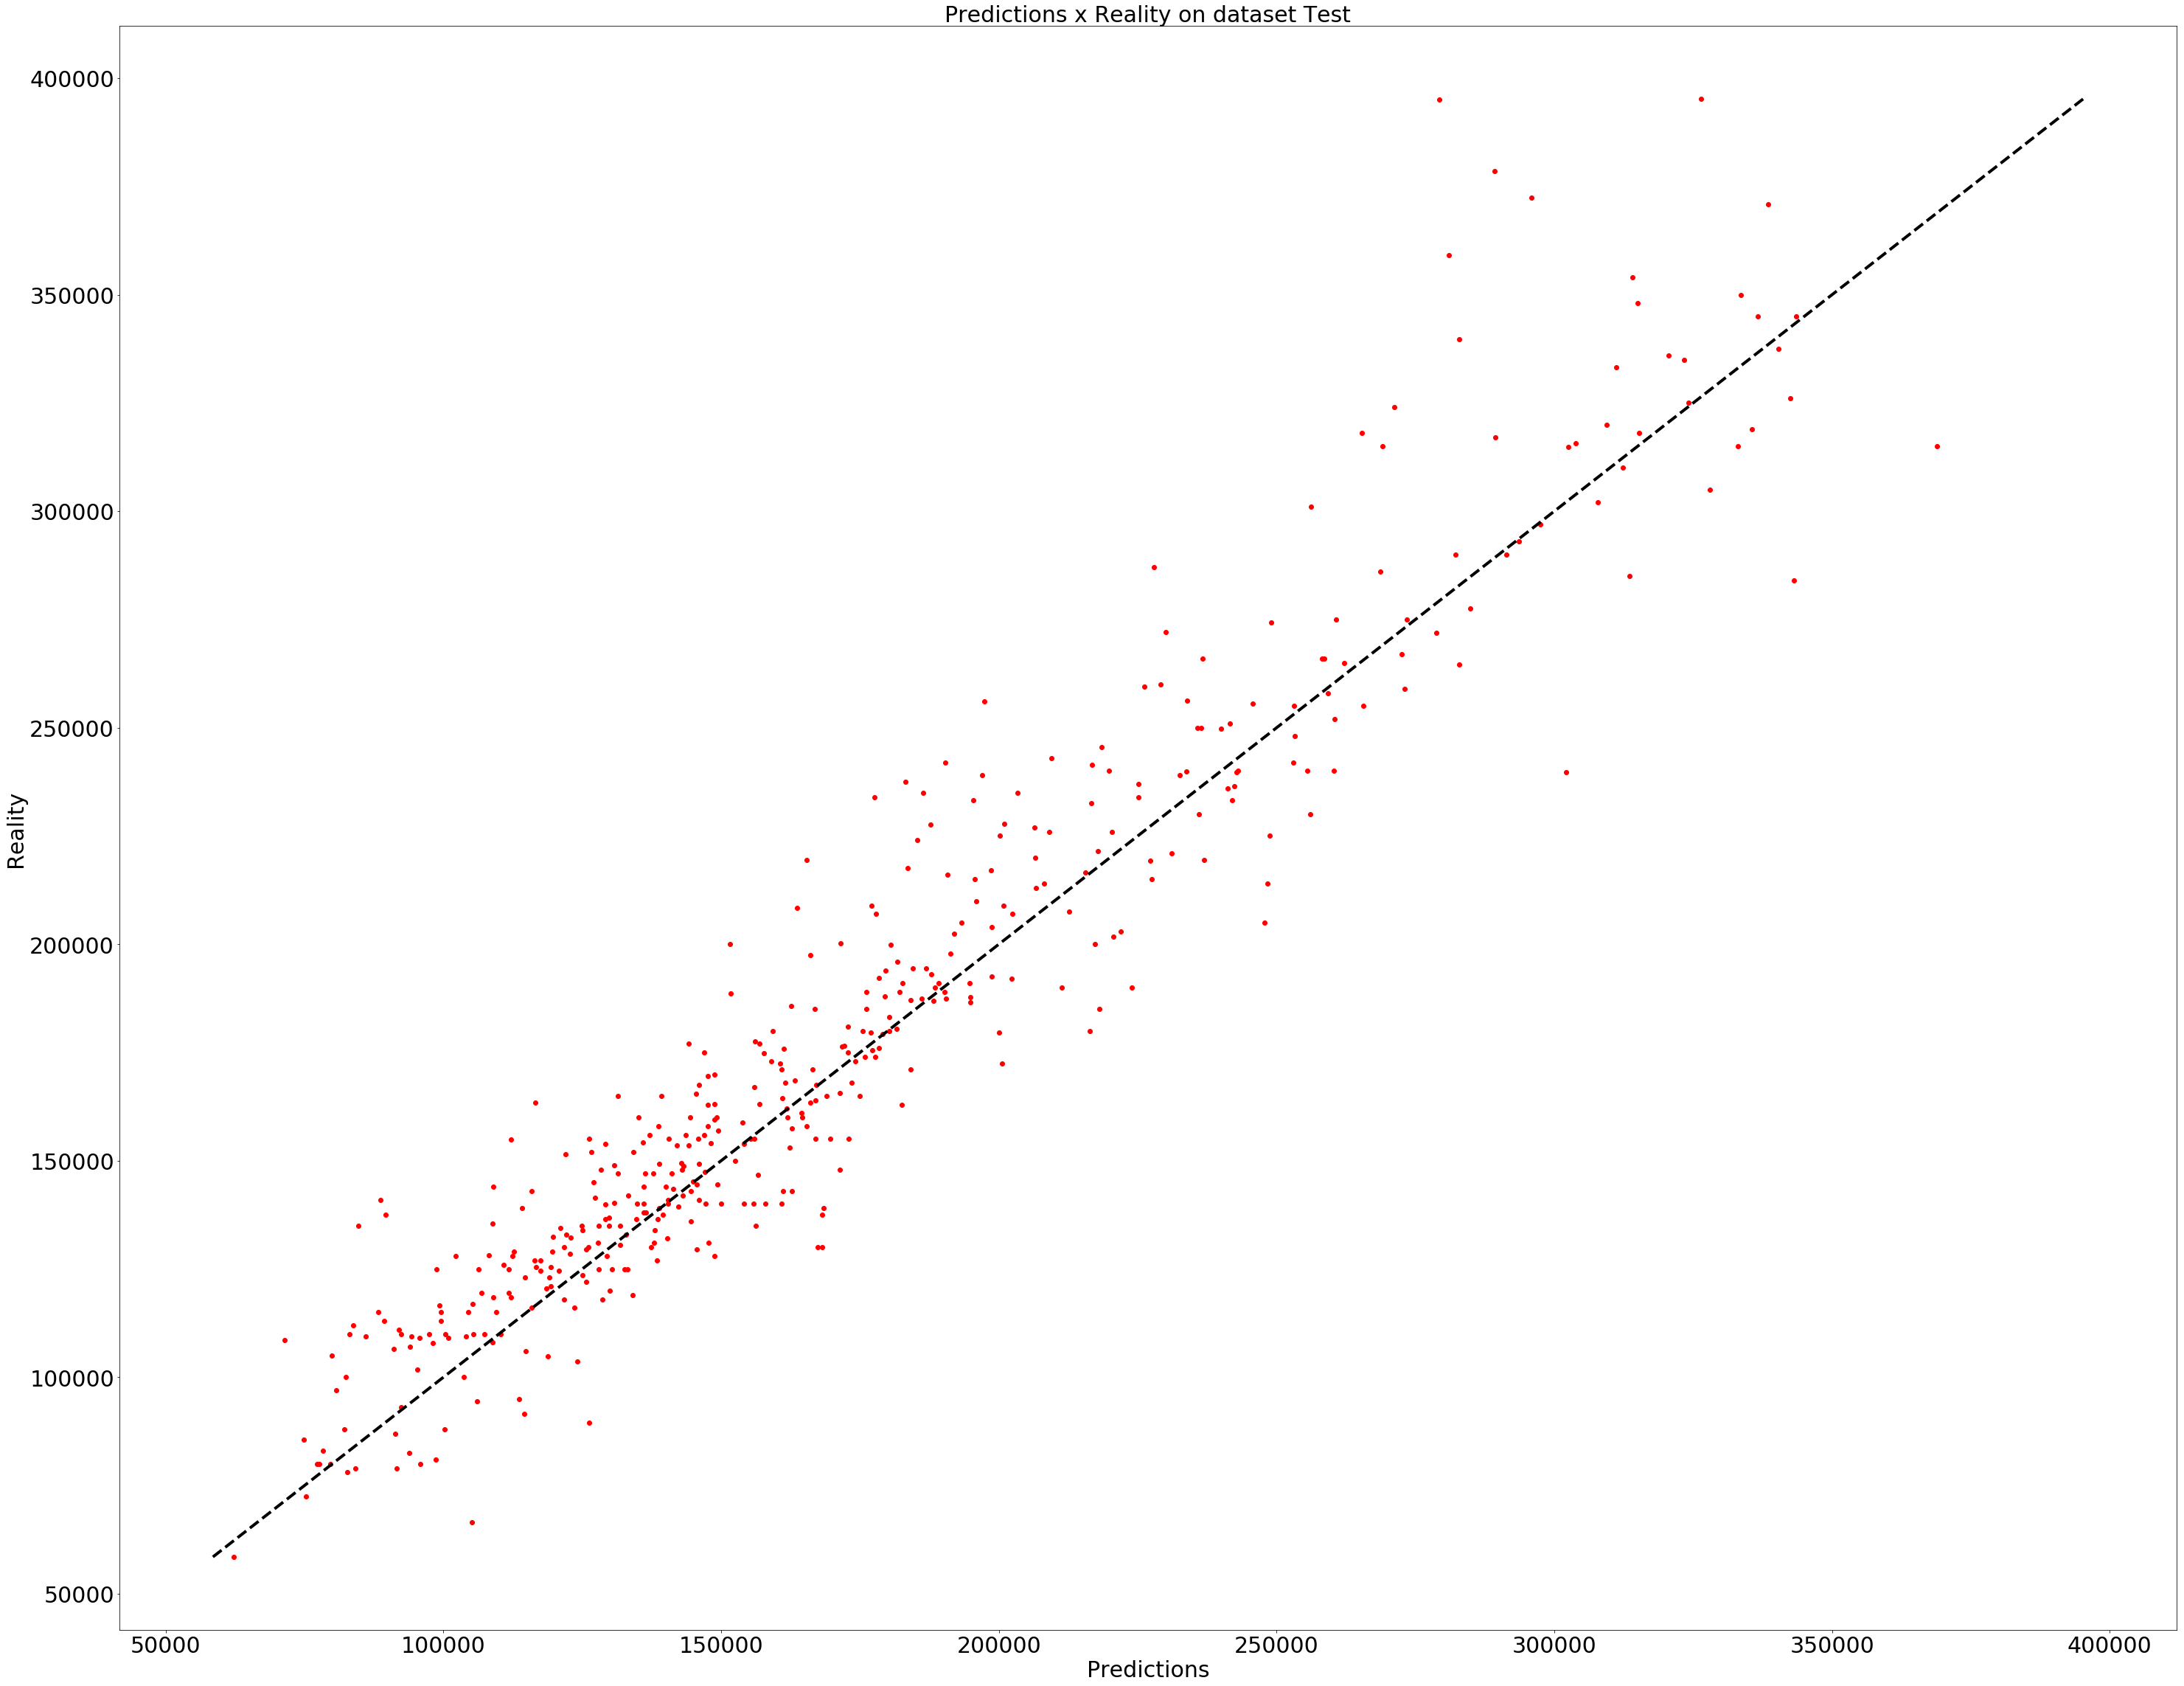

In [23]:
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

fig, ax = plt.subplots(figsize=(50, 40))

plt.style.use('ggplot')
plt.plot(predictions.values, reality.values, 'ro')
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Reality', fontsize = 30)
plt.title('Predictions x Reality on dataset Test', fontsize = 30)
ax.plot([reality.min(), reality.max()], [reality.min(), reality.max()], 'k--', lw=4)
plt.show()

In [24]:
y_predict = regressor.predict(input_fn=lambda: input_fn(test, pred = True))

def to_submit(pred_y,name_out):
    y_predict = list(itertools.islice(pred_y, test.shape[0]))
    y_predict = pd.DataFrame(prepro_y.inverse_transform(np.array(y_predict).reshape(len(y_predict),1)), columns = ['SalePrice'])
    y_predict = y_predict.join(ID)
    y_predict.to_csv(name_out + '.csv',index=False)
    
to_submit(y_predict, "submission_continuous")

VI。漏Relu
另一个激活函数的例子:Leaky Relu !我们可以使用Relu创建这个新函数。提醒一下Relu是Max(x,0) Leaky Relu是Max(x， *x)函数。我们可以取= 0。01

In [25]:
def leaky_relu(x):
    return tf.nn.relu(x) - 0.01 * tf.nn.relu(-x)

In [26]:
# Model
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = leaky_relu, hidden_units=[200, 100, 50, 25, 12])
    
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn=lambda: input_fn(training_set), steps=2000)

# Evaluation on the test set created by train_test_split
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)

DNNRegressor(params={'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None, 'optimizer': None, 'feature_columns': (_RealValuedColumn(column_name='MSSubClass', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotFrontage', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotArea', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallQual', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallCond', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearBuilt', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearRemodAdd', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='MasVnrArea', dimension=1, default_value=None, d

In [27]:
# Display the score on the testing set
# 0.002X in average
loss_score2 = ev["loss"]
print("Final Loss on the testing set with Leaky Relu: {0:f}".format(loss_score2))

Final Loss on the testing set with Leaky Relu: 0.002500


In [28]:
# Predictions
y_predict = regressor.predict(input_fn=lambda: input_fn(test, pred = True))
to_submit(y_predict, "Leaky_relu")

In [29]:
# Model
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.elu, hidden_units=[200, 100, 50, 25, 12])
    
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn=lambda: input_fn(training_set), steps=2000)

# Evaluation on the test set created by train_test_split
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)

loss_score3 = ev["loss"]

DNNRegressor(params={'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None, 'optimizer': None, 'feature_columns': (_RealValuedColumn(column_name='MSSubClass', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotFrontage', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotArea', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallQual', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallCond', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearBuilt', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearRemodAdd', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='MasVnrArea', dimension=1, default_value=None, d

In [30]:
print("Final Loss on the testing set with Elu: {0:f}".format(loss_score3))

Final Loss on the testing set with Elu: 0.002450


In [31]:
# Predictions
y_predict = regressor.predict(input_fn=lambda: input_fn(test, pred = True))
to_submit(y_predict, "Elu")

我们有3个提交有3种不同的激活功能。但是我们用连续的特征建立了我们的模型。如果你想提高成绩，请下载这3份作品并提交给排行榜。现在我们来看看如何通过添加分类特征来构建另一个模型。

七世。用于连续和分类特征的深度神经网络
对于这一部分，我重复前面通过添加分类特性可以找到的相同函数。

In [32]:
# Import and split
train = pd.read_csv('D:/news/train.csv')
train.drop('Id',axis = 1, inplace = True)
train_numerical = train.select_dtypes(exclude=['object'])
train_numerical.fillna(0,inplace = True)
train_categoric = train.select_dtypes(include=['object'])
train_categoric.fillna('NONE',inplace = True)
train = train_numerical.merge(train_categoric, left_index = True, right_index = True) 

test = pd.read_csv('D:/news/test.csv')
ID = test.Id
test.drop('Id',axis = 1, inplace = True)
test_numerical = test.select_dtypes(exclude=['object'])
test_numerical.fillna(0,inplace = True)
test_categoric = test.select_dtypes(include=['object'])
test_categoric.fillna('NONE',inplace = True)
test = test_numerical.merge(test_categoric, left_index = True, right_index = True) 

In [33]:
# Removie the outliers
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train_numerical)
y_noano = clf.predict(train_numerical)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train_numerical = train_numerical.iloc[y_noano[y_noano['Top'] == 1].index.values]
train_numerical.reset_index(drop = True, inplace = True)

train_categoric = train_categoric.iloc[y_noano[y_noano['Top'] == 1].index.values]
train_categoric.reset_index(drop = True, inplace = True)

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)

IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
        max_features=1.0, max_samples=100, n_estimators=100, n_jobs=None,
        random_state=42, verbose=0)

array([   0,    1,    2, ..., 1456, 1458, 1459], dtype=int64)

In [34]:
col_train_num = list(train_numerical.columns)
col_train_num_bis = list(train_numerical.columns)

col_train_cat = list(train_categoric.columns)

col_train_num_bis.remove('SalePrice')

mat_train = np.matrix(train_numerical)
mat_test  = np.matrix(test_numerical)
mat_new = np.matrix(train_numerical.drop('SalePrice',axis = 1))
mat_y = np.array(train.SalePrice)

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y.reshape(1314,1))

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

train_num_scale = pd.DataFrame(prepro.transform(mat_train),columns = col_train)
test_num_scale  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

MinMaxScaler(copy=True, feature_range=(0, 1))

MinMaxScaler(copy=True, feature_range=(0, 1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [35]:
train[col_train_num] = pd.DataFrame(prepro.transform(mat_train),columns = col_train_num)
test[col_train_num_bis]  = test_num_scale

这里的主要变化是以categorical_features开头的行…可以使用其他函数来准备分类数据。

In [36]:
# List of features
COLUMNS = col_train_num
FEATURES = col_train_num_bis
LABEL = "SalePrice"

FEATURES_CAT = col_train_cat

engineered_features = []

for continuous_feature in FEATURES:
    engineered_features.append(
        tf.contrib.layers.real_valued_column(continuous_feature))

for categorical_feature in FEATURES_CAT:
    sparse_column = tf.contrib.layers.sparse_column_with_hash_bucket(
        categorical_feature, hash_bucket_size=1000)

    engineered_features.append(tf.contrib.layers.embedding_column(sparse_id_column=sparse_column, dimension=16,combiner="sum"))
                                 
# Training set and Prediction set with the features to predict
training_set = train[FEATURES + FEATURES_CAT]
prediction_set = train.SalePrice

# Train and Test 
x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES + FEATURES_CAT] ,
                                                    prediction_set, test_size=0.33, random_state=42)
y_train = pd.DataFrame(y_train, columns = [LABEL])
training_set = pd.DataFrame(x_train, columns = FEATURES + FEATURES_CAT).merge(y_train, left_index = True, right_index = True)

# Training for submission
training_sub = training_set[FEATURES + FEATURES_CAT]
testing_sub = test[FEATURES + FEATURES_CAT]

In [37]:
# Same thing but for the test set
y_test = pd.DataFrame(y_test, columns = [LABEL])
testing_set = pd.DataFrame(x_test, columns = FEATURES + FEATURES_CAT).merge(y_test, left_index = True, right_index = True)

In [38]:
training_set[FEATURES_CAT] = training_set[FEATURES_CAT].applymap(str)
testing_set[FEATURES_CAT] = testing_set[FEATURES_CAT].applymap(str)

def input_fn_new(data_set, training = True):
    continuous_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
    
    categorical_cols = {k: tf.SparseTensor(
        indices=[[i, 0] for i in range(data_set[k].size)], values = data_set[k].values, dense_shape = [data_set[k].size, 1]) for k in FEATURES_CAT}

    # Merges the two dictionaries into one.
    feature_cols = dict(list(continuous_cols.items()) + list(categorical_cols.items()))
    
    if training == True:
        # Converts the label column into a constant Tensor.
        label = tf.constant(data_set[LABEL].values)

        # Returns the feature columns and the label.
        return feature_cols, label
    
    return feature_cols

# Model
regressor = tf.contrib.learn.DNNRegressor(feature_columns = engineered_features, 
                                          activation_fn = tf.nn.relu, hidden_units=[200, 100, 50, 25, 12])

In [39]:
categorical_cols = {k: tf.SparseTensor(indices=[[i, 0] for i in range(training_set[k].size)], values = training_set[k].values, dense_shape = [training_set[k].size, 1]) for k in FEATURES_CAT}

In [40]:
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn = lambda: input_fn_new(training_set) , steps=2000)

DNNRegressor(params={'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None, 'optimizer': None, 'feature_columns': (_RealValuedColumn(column_name='MSSubClass', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotFrontage', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotArea', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallQual', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallCond', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearBuilt', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearRemodAdd', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='MasVnrArea', dimension=1, default_value=None, d

In [41]:
ev = regressor.evaluate(input_fn=lambda: input_fn_new(testing_set, training = True), steps=1)

In [42]:
loss_score4 = ev["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score4))

Final Loss on the testing set: 0.002070


八世。预测国际清算银行

In [43]:
# Predictions
y = regressor.predict(input_fn=lambda: input_fn_new(testing_set))
predictions = list(itertools.islice(y, testing_set.shape[0]))
predictions = pd.DataFrame(prepro_y.inverse_transform(np.array(predictions).reshape(434,1)))

Text(0.5, 0, 'Predictions')

Text(0, 0.5, 'Reality')

Text(0.5, 1.0, 'Predictions x Reality on dataset Test')

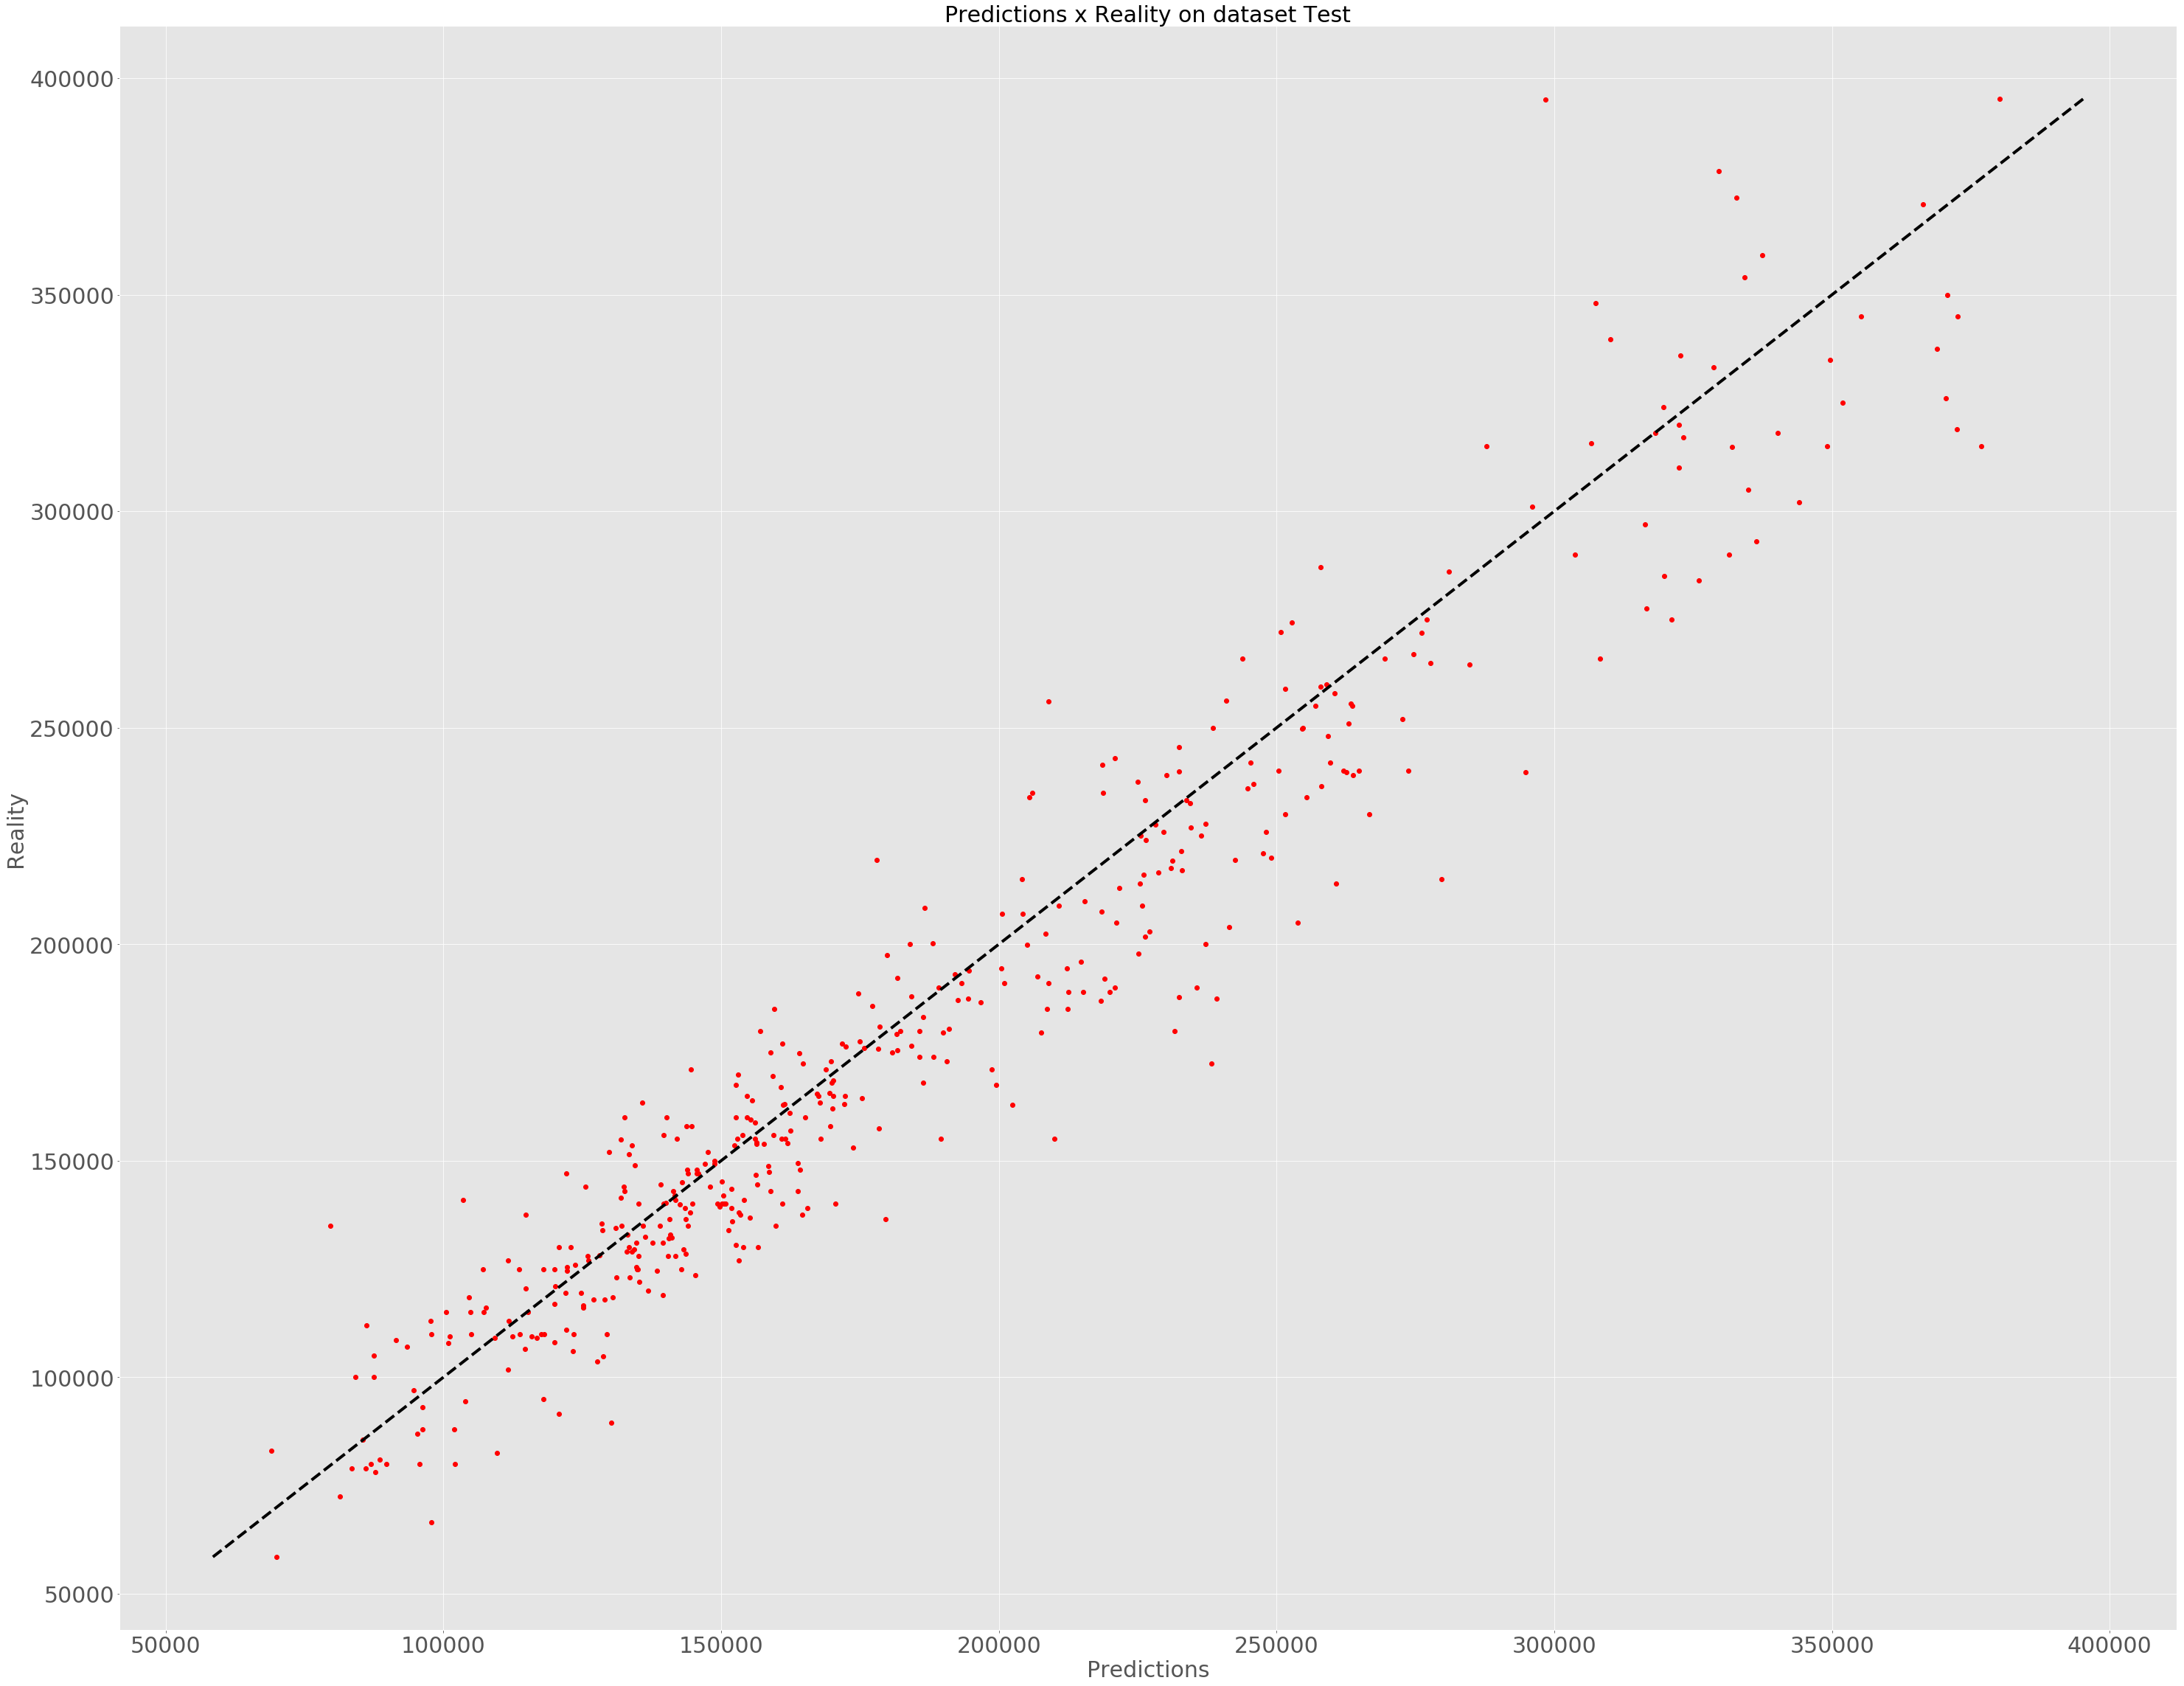

In [44]:
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

fig, ax = plt.subplots(figsize=(50, 40))

plt.style.use('ggplot')
plt.plot(predictions.values, reality.values, 'ro')
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Reality', fontsize = 30)
plt.title('Predictions x Reality on dataset Test', fontsize = 30)
ax.plot([reality.min(), reality.max()], [reality.min(), reality.max()], 'k--', lw=4)
plt.show()

In [45]:
y_predict = regressor.predict(input_fn=lambda: input_fn_new(testing_sub, training = False))

In [46]:
to_submit(y_predict, "submission_cont_categ")

 
第九。肤浅的网络
在这一部分中，我们将使用一个具有多个单元的隐藏层来扩展架构。问题是:你需要多少单元才能在排行榜上取得好成绩?我们试着用1000单位的激活函数Relu。

In [ ]:
# Model
regressor = tf.contrib.learn.DNNRegressor(feature_columns = engineered_features, 
                                          activation_fn = tf.nn.relu, hidden_units=[1000])

In [ ]:
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn = lambda: input_fn_new(training_set) , steps=2000)

In [ ]:
ev = regressor.evaluate(input_fn=lambda: input_fn_new(testing_set, training = True), steps=1)
loss_score5 = ev["loss"]

In [ ]:
print("Final Loss on the testing set: {0:f}".format(loss_score5))

In [ ]:
y_predict = regressor.predict(input_fn=lambda: input_fn_new(testing_sub, training = False))    
to_submit(y_predict, "submission_shallow")

  
10结论

In [ ]:
list_score = [loss_score1, loss_score2, loss_score3, loss_score4,loss_score5]
list_model = ['Relu_cont', 'LRelu_cont', 'Elu_cont', 'Relu_cont_categ','Shallow_1ku']

In [ ]:
import matplotlib.pyplot as plt; plt.rcdefaults()

plt.style.use('ggplot')
objects = list_model
y_pos = np.arange(len(objects))
performance = list_score
 
plt.barh(y_pos, performance, align='center', alpha=0.9)
plt.yticks(y_pos, objects)
plt.xlabel('Loss ')
plt.title('Model compared without hypertuning')
 
plt.show()

所以，我希望这个小小的介绍能对大家有所帮助!使用这段代码，您可以使用Tensorflow构建一个回归模型，该模型具有连续和分类特征，并添加一个新的激活函数(LeakyRelu)。如果您想要改进结果，您可以在整个数据上重新构建模型。你可以看到我只使用了67%的训练集来构建我的模型。
拿我的代码来玩:更多的超参数，100%的训练集来构建下一个模型，尝试使用其他激活函数等等……